# Laboratorium nr 9

In [ ]:
import sklearn
import pandas as pd

## Wstęp teoretyczny: Drzewa decyzyjne

### Czym są drzewa decyzyjne?

Drzewo decyzyjne to model uczenia maszynowego, który przedstawia zbiór reguł decyzyjnych w strukturze przypominającej drzewo. Każdy węzeł wewnętrzny odpowiada testowi logicznemu na jednej z cech, każda gałąź reprezentuje wynik testu, a liść drzewa wskazuje przewidywaną klasę (dla klasyfikacji) lub wartość (dla regresji).

---

### 1. **Podział danych (splitting)**

Aby zbudować drzewo, algorytm rekurencyjnie dzieli zbiór danych w punktach, które maksymalizują „czystość” zbiorów potomnych. Dobór najlepszego podziału opiera się na **miernikach nieczystości (impurity)**.

### 2. **Miary nieczystości (impurity measures)**

#### a) **Entropia (Entropy)**

$$
\text{Entropy}(S) = - \sum_{i=1}^C p_i \log_2(p_i)
$$

gdzie:
- $ C $ — liczba klas
- $ p_i $ — proporcja próbek należących do klasy $ i $ w zbiorze $ S $

Entropia osiąga minimum, gdy wszystkie próbki należą do jednej klasy (czysty zbiór) i maksimum, gdy rozkład klas jest równomierny.

#### b) **Zysk informacyjny (Information Gain)**

$$
\text{Information Gain}(S, A) = \text{Entropy}(S) - \sum_{v \in \text{Values}(A)} \frac{|S_v|}{|S|} \text{Entropy}(S_v)
$$

- $ S_v $ — podzbiór danych, dla których cecha $ A $ przyjmuje wartość $ v $

Algorytm ID3 buduje drzewo, wybierając atrybut z największym zyskiem informacyjnym.

#### c) **Wskaźnik Giniego (Gini Index)**

$$
\text{Gini}(S) = 1 - \sum_{i=1}^C p_i^2
$$

Stosowany przez algorytm CART (używany w `scikit-learn`). Preferuje szybkie i dobrze działające rozdzielenia, nawet kosztem większej głębokości drzewa.

---

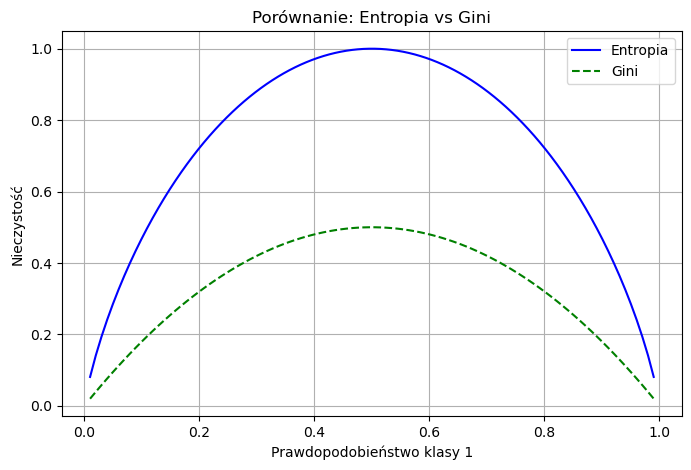

In [6]:
import numpy as np
import matplotlib.pyplot as plt

p = np.linspace(0.01, 0.99, 100)
entropy = -p * np.log2(p) - (1 - p) * np.log2(1 - p)
gini = 1 - p**2 - (1 - p)**2

plt.figure(figsize=(8, 5))
plt.plot(p, entropy, label='Entropia', color='blue')
plt.plot(p, gini, label='Gini', color='green', linestyle='--')
plt.xlabel('Prawdopodobieństwo klasy 1')
plt.ylabel('Nieczystość')
plt.title('Porównanie: Entropia vs Gini')
plt.legend()
plt.grid(True)
plt.show()

## Proces budowy drzewa

1. Oblicz impurity (entropia lub Gini) dla aktualnego zbioru.
2. Dla każdej cechy wyznacz impurity po podziale.
3. Wybierz cechę i próg, który maksymalizuje poprawę czystości (największy spadek impurity).
4. Podziel dane i powtórz dla każdego potomnego węzła.
5. Zatrzymaj się, gdy:
   - impurity = 0
   - liczba próbek < `min_samples_split`
   - osiągnięto `max_depth`


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree
import numpy as np

# Dane: tylko dwie cechy dla łatwej wizualizacji
iris = load_iris()
X = iris.data[:, [0, 2]]  # sepal length & petal length
y = iris.target

# Budujemy pełne drzewo
full_tree = DecisionTreeClassifier(max_depth=4, criterion="gini", random_state=42)
full_tree.fit(X, y)

# Lista kroków — drzewa o rosnącej głębokości
trees = [DecisionTreeClassifier(max_depth=d, criterion="gini", random_state=42).fit(X, y) for d in range(1, 5)]

# Tworzymy figurę
fig, ax = plt.subplots(figsize=(10, 6))

def update(frame):
    ax.clear()
    tree = trees[frame]
    plot_tree(tree,
              feature_names=["sepal length", "petal length"],
              class_names=iris.target_names.tolist(),
              filled=True,
              ax=ax)
    ax.set_title(f"Drzewo decyzyjne - głębokość: {frame + 1}", fontsize=14)

ani = FuncAnimation(fig, update, frames=len(trees), repeat=False, interval=1500)

plt.close()

from IPython.display import HTML
HTML(ani.to_jshtml())


## Pruning

Drzewa mogą **nadmiernie dopasowywać się** (overfitting), jeśli są zbyt głębokie. Aby temu zapobiec, stosuje się:

- **Przycinkę wstępną** (`pre-pruning`): ograniczenia jak `max_depth`, `min_samples_leaf`.
- **Przycinkę wtórną** (`post-pruning`): usuwanie gałęzi, które nie poprawiają wyników na zbiorze walidacyjnym.

---

## Hiperparametry w `DecisionTreeClassifier`

- `criterion`: `"gini"` lub `"entropy"`
- `max_depth`: maksymalna głębokość drzewa
- `min_samples_split`: minimalna liczba próbek, by podzielić węzeł
- `min_samples_leaf`: minimalna liczba próbek w liściu
- `max_features`: maksymalna liczba cech branych pod uwagę przy podziale

---

## Zalety i wady

**Zalety:**
- Łatwe do interpretacji i wizualizacji
- Nie wymagają skalowania danych
- Obsługują cechy kategoryczne i liczbowe

**Wady:**
- Wysokie ryzyko nadmiernego dopasowania
- Niestabilność: małe zmiany w danych mogą prowadzić do zupełnie innego drzewa
- Gorsze wyniki niż modele zespołowe (np. Random Forest, XGBoost)

### Zadanie nr 1 (6 punktów)
Twoim zadaniem jest stworzenie modelu klasyfikacyjnego na podstawie rzeczywistego zbioru danych, który będzie przewidywać, czy dana osoba ma cukrzycę. Użyj drzewa decyzyjnego, a następnie przeprowadź analizę istotności cech oraz zwizualizuj otrzymany model.

1. Użyj zbioru danych **Pima Indians Diabetes Dataset**, dostępnego m.in. w serwisie Kaggle lub poprzez `sklearn.datasets`. Dane zawierają m.in.:
- liczba ciąż (`Pregnancies`)
- poziom glukozy (`Glucose`)
- ciśnienie krwi (`BloodPressure`)
- grubość fałdu skórnego (`SkinThickness`)
- poziom insuliny (`Insulin`)
- wskaźnik masy ciała (`BMI`)
- funkcja genetyczna (`DiabetesPedigreeFunction`)
- wiek (`Age`)
- wynik: 0 (brak cukrzycy), 1 (cukrzyca)


2. Wczytaj dane
- Użyj biblioteki `pandas`, aby załadować dane.
- Rozdziel dane na zmienne objaśniające (`X`) i zmienną docelową (`y`).

3. Budowa drzewa decyzyjnego
- Użyj `DecisionTreeClassifier` z `scikit-learn`.
- Podziel dane na zbiór treningowy i testowy (np. `train_test_split`).
- Użyj `cross_val_score` do walidacji krzyżowej.

4. Zrób ranking cech, korzystając z `feature_importances_` (selekcja cech).

5. Optymalizacja hiperparametrów
- Użyj `GridSearchCV`, aby dobrać:
  - `max_depth`
  - `min_samples_split`
  - `criterion` (`gini`, `entropy`)
- Przedstaw najlepsze parametry i wyniki.

6. Wizualizacja drzewa
- Użyj `plot_tree` z `matplotlib` **lub** `export_graphviz` + `graphviz`.
- Zadbaj o:
  - wyświetlenie nazw cech
  - czytelność i estetykę grafu

7. Analiza wyników
- Oblicz:
  - `accuracy`, `precision`, `recall`, `f1-score`
- Pokaż macierz pomyłek (np. `confusion_matrix` + `seaborn.heatmap`)
- Zinterpretuj wyniki — które cechy są najistotniejsze? Jak model radzi sobie z klasyfikacją?

In [4]:
from sklearn.datasets import load_diabetes
X,y = load_diabetes(return_X_y=True)

### Zadanie nr 2 (4 punkty)

Użyj zbioru danych **Breast Cancer Wisconsin** (`sklearn.datasets.load_breast_cancer`), a następnie:

1. Wczytaj dane i podziel je na zbiór treningowy i testowy w proporcji 70/30 (użyj `train_test_split`).
2. Wytrenuj pełne drzewo decyzyjne (`DecisionTreeClassifier`), bez ograniczenia głębokości.
4. Zastosuj post-pruning, korzystając z metody `cost_complexity_pruning_path`.
5. Wytrenuj kilka drzew z różnymi hiperparametrami `ccp_alpha`, używając atrybutu `ccp_alphas` dostępnego w obiekcie zwróconym przez metodę `cost_complexity_pruning_path`.
6. Narysuj wykres: dokładność na zbiorze testowym vs. `ccp_alpha`.